<a href="https://colab.research.google.com/github/FlyingWorkshop/DiffusionGNNTutorial/blob/main/simple_edm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!pip install torch_geometric
!pip install rdkit

Data(x=[16, 11], edge_index=[2, 40], edge_attr=[40, 4], y=[1, 19], pos=[16, 3], z=[16], smiles='[H]C1([H])[N@H+]2[C@@]3([H])[C@@]14O[C@@]1([H])[C@@]([H])([C@]24[H])[C@]13[H]', name='gdb_133885', idx=[1])


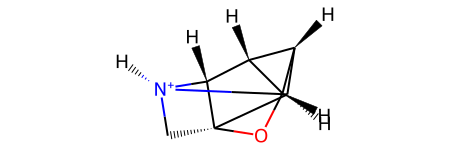

In [9]:
# load QM9 dataset
# documentation: https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.datasets.QM9.html?highlight=qm9#torch_geometric.datasets.QM9

from torch_geometric.datasets import QM9
from rdkit import Chem

dataset = QM9(root='drive/MyDrive/Tutorial/data/QM9/')
ex_hard = dataset[-1]
print(ex_hard)
mol = Chem.MolFromSmiles(ex_hard.smiles)
mol

In [6]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from scipy.spatial.transform import Rotation
import numpy as np
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [21]:
class SimpleEGCL(nn.Module):
  def __init__(self, hidden=32):
    super().__init__()
    self.mlp = nn.Sequential(
        nn.Linear(3, hidden),
        nn.SiLU(),
        nn.Linear(hidden, 3)
    )

  def forward(self, pos):
    diff = pos - pos.unsqueeze(1)
    norm = torch.norm(diff, dim=-1)
    normalized = diff / (norm + 1).unsqueeze(-1)
    pred_noise = self.mlp(normalized)
    return pos + pred_noise


class SimpleEGNN(nn.Module):
  def __init__(self, num_layers: int = 1):
    super().__init__()
    self.layers = nn.ModuleList([SimpleEGCL() for _ in range(num_layers)])

  def forward(self, pos):
    for layer in self.layers:
      pos = layer(pos)
    return pos


class SimpleEDM:
  def __init__(self, max_timesteps: int = 1000, lr=1e-3):
    self.model = SimpleEGNN()
    self.loss_fn = nn.MSELoss()
    self.optimizer = optim.Adam(self.model.parameters(), lr=lr)

    self.max_timesteps = max_timesteps
    self.normal_dist = torch.distributions.MultivariateNormal(torch.zeros(3), torch.eye(3))
    self.uniform_dist = torch.distributions.Uniform(low=0, high=max_timesteps)

  def alpha(self, t):
    return np.sqrt(1 - self.sigma(t))

  def sigma(self, t):
    return 0.005

  def sample_noise(self, n):
    noise = self.normal_dist.sample(sample_shape=(n,))  # noise.shape = (n, 3)
    noise -= torch.mean(noise, dim=0, keepdim=True)
    return noise

  def predict_noise(self, pos):
    pred_noise = self.model(pos) - pos
    return pred_noise

  def optimize(self, example, plot=False, verbose=False):
    if plot:
      history = []

    pos = example.pos
    n = pos.shape[0]
    for t in range(self.max_timesteps):
      self.optimizer.zero_grad()
      if t == 0:
        noise = torch.zeros_like(pos)
      else:
        noise = self.sample_noise(n)
        pos = self.alpha(t) * pos + self.sigma(t) * noise
      pred_noise = self.predict_noise(pos)
      loss = self.loss_fn(pred_noise, noise)
      loss.backward()
      self.optimizer.step()

      if plot:
        history.append(loss.detach().numpy())
      if verbose:
        print(f"{t}: {loss.detach().numpy()}")

    if plot:
      plt.plot(range(len(history)), history)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([16, 3])) that is different to the input size (torch.Size([16, 16, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


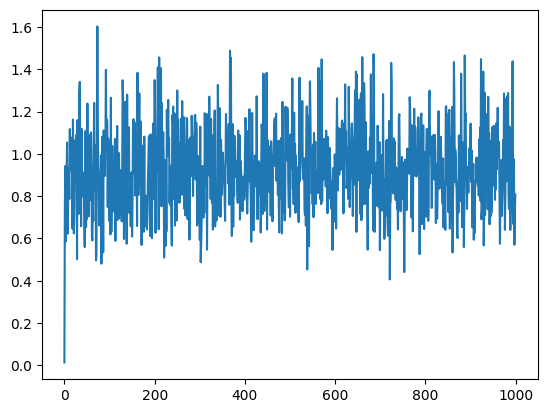

In [23]:
edm = SimpleEDM()
edm.optimize(ex_hard, plot=True)